# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

Algo muy típico en trabajo de data scientist

![](../theory/sliding_windows_google.png)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [4]:
# Total time points
N = 3000
# Time point to partition train/test splits
Tp = 750   

t=np.arange(0,N)
x=(2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
df.head()

,Data
0,0.248993
1,0.383328
2,0.422944
3,-0.532607
4,0.351929


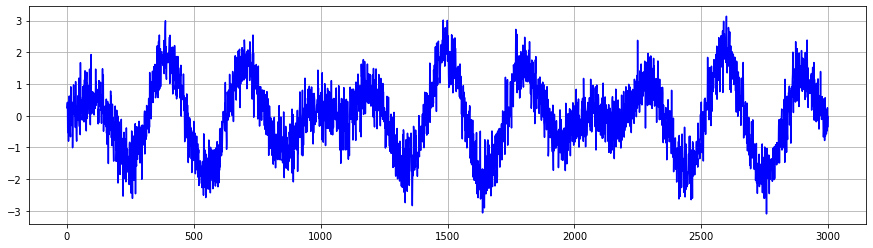

In [5]:
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True)
plt.show()

In [13]:
# Entramiento con todos los datos
to_train = df.values
print("to_train:", to_train.shape)

to_train: (3000, 1)


In [14]:
step = 1
to_train = np.append(to_train,np.repeat(to_train[-1,],step))
to_train.shape

(3001,)

In [17]:
print("to_train[-1,] --> ", to_train[-1,])
print("---------------")
print("np.repeat(to_train[-1],step) --> ",np.repeat(to_train[-1],step) )
print("---------------")
print("to_train[-8:] --> ", to_train[-8:])


to_train[-1,] -->  -0.02898251889477807
---------------
np.repeat(to_train[-1],step) -->  [-0.02898252]
---------------
to_train[-8:] -->  [-0.5735935   0.0632995   0.0160979  -0.47783516  0.24807889 -0.36173033
 -0.02898252 -0.02898252]


In [20]:
step = 4

# add step elements into train and test
train = np.append(to_train,np.repeat(to_train[-1,],step))
train

array([ 0.24899341,  0.38332776,  0.42294373, ..., -0.02898252,
       -0.02898252, -0.02898252])

In [21]:
print("Train data length:", train.shape)

Train data length: (3005,)


In [22]:
# Convertir un array en multidimensional
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [23]:
X_train,y_train = convertToMatrix(train,step)


print("X_train.shape",X_train.shape)
print("y_train.shape",y_train.shape)

X_train.shape (3001, 4)
y_train.shape (3001,)


In [25]:
print("X_train[0] --> ", X_train[0])
print("X_train[1] --> ", X_train[1])
print("X_train[2] --> ", X_train[2])
print("X_train[3] --> ", X_train[3])

X_train[0] -->  [ 0.24899341  0.38332776  0.42294373 -0.5326069 ]
X_train[1] -->  [ 0.38332776  0.42294373 -0.5326069   0.35192859]
X_train[2] -->  [ 0.42294373 -0.5326069   0.35192859  0.21210053]
X_train[3] -->  [-0.5326069   0.35192859  0.21210053 -0.80320107]


In [26]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train

array([[[ 0.24899341,  0.38332776,  0.42294373, -0.5326069 ]],

       [[ 0.38332776,  0.42294373, -0.5326069 ,  0.35192859]],

       [[ 0.42294373, -0.5326069 ,  0.35192859,  0.21210053]],

       ...,

       [[-0.36173033, -0.02898252, -0.02898252, -0.02898252]],

       [[-0.02898252, -0.02898252, -0.02898252, -0.02898252]],

       [[-0.02898252, -0.02898252, -0.02898252, -0.02898252]]])

### Keras model with SimpleRNN layer
        256 neurons in the RNN layer
        32 denurons in the densely connected layer
        a single neuron for the output layer
        ReLu activation
        learning rate: 0.001

In [27]:
def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [28]:
model = build_simple_rnn() # Taking the defaults
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               17024     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,185
Trainable params: 21,185
Non-trainable params: 0
_________________________________________________________________


### A simple callback class to show a message every 50 epochs

In [29]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Fit the model
Con batch_size = 16 lo que haríamos es que cogemos los datos de esta forma:

(750, 16, 4)
Cogemos 16 filas con 4 datos

In [31]:
batch_size=16
num_epochs = 1000

model.fit(X_train,y_train, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


### Plot loss

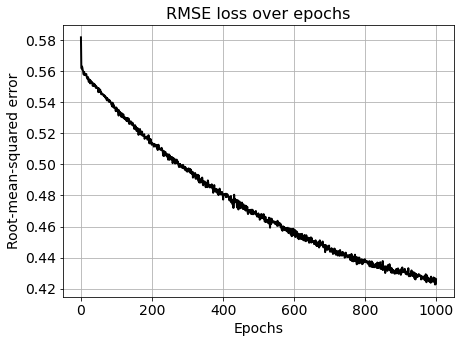

In [32]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
LO ÚNICO QUE SACO EN CLARO ES QUE CON ESTE MODELO EL RMSE EN O,56 EMPIEZA A FLUCTUAR MIENTRAS QUE EN EL EJEMPLO ES EN 0,55.

Predictions
Note that the model was fitted only with the X_train and y_train data.

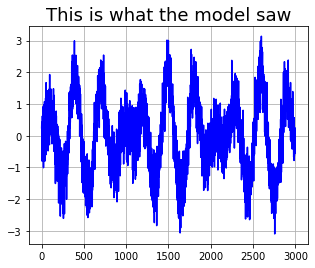

In [34]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(X_train[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [35]:
trainPredict = model.predict(X_train)

predicted = np.concatenate((trainPredict),axis=0)

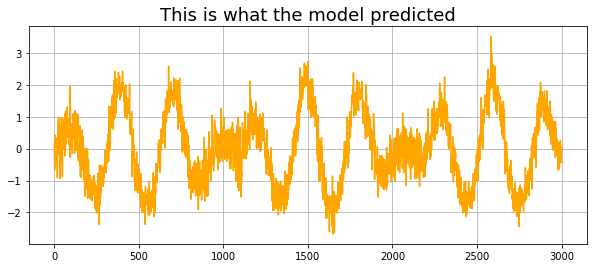

In [37]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(predicted,c='orange')
plt.grid(True)
plt.show()